In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from itertools import product, chain, combinations

warnings.simplefilter(action='ignore')

In [2]:
def profit_score (conf_matrix, d=0.2, lgd=0.8):
    tn, fp, fn = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0]
    return (tn*d - fn*lgd)/(d*(fp+tn))

def FNR(conf_matrix):
    tn, fn = conf_matrix[0][0], conf_matrix[1][0]
    return (fn/(tn+fn))

def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def gen_dataset(data, target, main_feats, feats_add, feats_encod, regr=True, return_feats=False):
    temp_data = data.copy()
    if feats_encod != 'False':
        origin_feats = list(temp_data.columns)
        temp_data = pd.get_dummies(temp_data, columns=feats_encod, drop_first=True)
        new_feats = [c for c in temp_data.columns if c not in origin_feats]
        temp_data = temp_data[main_feats+feats_add+new_feats]
    else:
        temp_data = temp_data[main_feats+feats_add]
        
    X_train, X_test, y_train, y_test = train_test_split(temp_data, target, test_size=0.15, random_state=42)
    
    if regr:
        sc = StandardScaler()
        X_train[main_feats+feats_add] = sc.fit_transform(X_train[main_feats+feats_add])
        X_test[main_feats+feats_add] = sc.transform(X_test[main_feats+feats_add])
    if return_feats:
        return X_train, X_test, y_train, y_test, list(X_train.columns)
    else:
        return X_train, X_test, y_train, y_test

In [4]:
data = pd.read_csv('data/clean_data_feats.csv')
target = data['bad']
data.drop(['bad'], axis=1, inplace=True)

In [9]:
param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 12,
    "num_leaves" : 4095,
    "learning_rate" : 0.15,
    "bagging_freq": 5,
    "bagging_fraction" : 0.77,
    "feature_fraction" : 0.3,
    "min_data_in_leaf": 20,
    #"min_sum_heassian_in_leaf": 10,
    "boost_from_average": "false",
    'class_weight': 'balanced',
    "lambda_l1" : 0,
    "lambda_l2" : 0.73,
    "seed": 42,
    "verbosity" : -1
}

param_list = {"lambda_l2" : [0.73],
              'learning_rate': [0.15],
              'depth_leaves': [[12, 4095]],
              "bagging_fraction" : [0.77],
              "feature_fraction" : [0.3]
                 }

In [10]:
def lgb_feats_search_params(params, params_list,  train, test, target, y_test, nbr=750,  esr=200, metrics_f=roc_auc_score, num_folds=5, rs=42):
    param_dict = {'lambda_l2': 0,
                'learning_rate': 0,
                'max_depth': 0,
                'num_leaves': 0,
                'bagging_fraction': 0,
                'feature_fraction': 0,
                'n_estimators': 0,
                #'min_sum_heassian_in_leaf': 0,
                'test_roc': 0,
                'val_roc': 0
                    }
    feats = [f for f in train.columns if f not in FEATURES_EXCLUDED]
    valid_roc_max = 0
    test_roc_max = 0
    count = 1
    
    for l2 in params_list['lambda_l2']:
        for lr in params_list['learning_rate']:
            for dl in params_list['depth_leaves']:
                for bf in params_list['bagging_fraction']:
                    for ff in params_list['feature_fraction']:
                        params['lambda_l2'] = l2
                        params['learning_rate'] = lr
                        params['max_depth'] = dl[0]
                        params['num_leaves'] = dl[1]
                        params['bagging_fraction'] = bf
                        params['feature_fraction'] = ff

                        oof_preds = np.zeros(len(train))
                        sub_preds = np.zeros(test.shape[0])
                        valid_roc = 0
                        test_roc = 0


                        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=rs)

                        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], target)):
                            train_x, train_y = train[feats].iloc[train_idx], target.iloc[train_idx]
                            valid_x, valid_y = train[feats].iloc[valid_idx], target.iloc[valid_idx]
                            lgb_train = lgb.Dataset(train_x,
                                                            label=train_y,
                                                            free_raw_data=False)
                            lgb_test = lgb.Dataset(valid_x,
                                                            label=valid_y,
                                                            free_raw_data=False)
                            reg = lgb.train(
                                            params,
                                            lgb_train,
                                            valid_sets=[lgb_train, lgb_test],
                                            valid_names=['train', 'test'],
                                            num_boost_round=nbr,
                                            early_stopping_rounds=esr,
                                            verbose_eval=False,

                            )

                            oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
                            valid_roc += metrics_f(valid_y, oof_preds[valid_idx])
                            sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits

                        valid_roc /= num_folds
                        test_roc = metrics_f(y_test, sub_preds)

                        if test_roc_max < test_roc:
                            print('Maximum is achieved!')
                            param_dict['lambda_l2'] = params['lambda_l2']
                            param_dict['learning_rate'] = params['learning_rate']
                            param_dict['max_depth'] = params['max_depth']
                            param_dict['num_leaves'] = params['num_leaves']
                            param_dict['bagging_fraction'] = params['bagging_fraction']
                            param_dict['feature_fraction'] = params['feature_fraction']
                            param_dict['val_roc'] = valid_roc
                            param_dict['test_roc'] = test_roc
                            valid_roc_max = valid_roc
                            test_roc_max = test_roc
                        
                        print("{}, l2: {}, lr: {}, depth: {}, num_leaves: {}, bf: {}, ff: {}, val_roc/test_roc: {:<8.7f}/{:<8.7f}\n".format(count,params['lambda_l2'], 
                                                                                                              params['learning_rate'],params['max_depth'],
                                                                                                              params['num_leaves'], params['bagging_fraction'], 
                                                                                                             params['feature_fraction'], valid_roc,  test_roc))
                        count+=1
    print(nbr, esr)    
    return param_dict

In [5]:
def cv_kfold_lgb(params, train, test, target, y_test, nbr=10000,  esr=2000, metrics_f=roc_auc_score, num_folds=5, rs=42, strat=True, shfl=True, rseed=42, info=False):
    print("Starting training. Train shape: {}, test shape: {}".format(train.shape, test.shape))
    
    if strat:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=shfl, random_state=rseed)
    else:
        folds = KFold(n_splits=num_folds, shuffle=shfl, random_state=rseed)

    oof_preds, sub_preds = np.zeros(train.shape[0]), np.zeros(test.shape[0])
    valid_roc = 0
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train.columns if f not in FEATURES_EXCLUDED]
    if info:
        print('Info:')
        print("Stratified: {}, Shuffle: {}, Folds:{}".format(strat, shfl, num_folds))
        print('Metrics: ', metrics_f)
        v_ev = 300
    else:
        v_ev = False
        
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[feats], target)):
        train_x, train_y = train[feats].iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train[feats].iloc[valid_idx], target.iloc[valid_idx]

        # set data structure
        print('Create lgbDataset!')
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)
        print('Train phase')
        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test'],
            num_boost_round=nbr,
            early_stopping_rounds=esr,
            verbose_eval=v_ev,

        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test[feats], num_iteration=reg.best_iteration) / folds.n_splits
        
        print("CV score in {} fold: {:<8.7f}\n".format(n_fold + 1, metrics_f(valid_y, oof_preds[valid_idx])))
        valid_roc += metrics_f(valid_y, oof_preds[valid_idx])
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = reg.feature_importance()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    valid_roc /= num_folds
    
    print("CV score on valid/test: {:<8.7f}/{:<8.7f}\n".format(valid_roc, metrics_f(y_test, sub_preds)))    
    return sub_preds, oof_preds, feature_importance_df

In [ ]:
%%time
preds, oof_preds, feat_imp = cv_kfold_lgb(lgb_params, X_train, X_test, y_train, y_test, nbr=15000,  esr=2000)

In [8]:
%%time
final_param_dict_new = lgb_feats_search_params(param, new_param_list, X_train, X_test, y_train, y_test, nbr=15000, esr=2000)

Maximum is achieved!
1, l2: 0.73, lr: 0.15, depth: 12, num_leaves: 4095, bf: 0.77, ff: 0.3, val_roc/test_roc: 0.8446605/0.8899471

15000 2000
Wall time: 1min 5s


In [6]:
lgb_param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting_type": 'gbdt',
    "max_depth" : 12,
    "num_leaves" : 4095,
    "learning_rate" : 0.15,
    "bagging_freq": 5,
    'n_estimators': 1000,
    "subsample_freq" : 0.77,
    "colsample_bytree" : 0.3,
    "boost_from_average": "false",
    'class_weight': 'balanced',
    "reg_lambda" : 0.73,
    "random_state": 42,
    "verbosity" : -1
}

In [16]:
def best_regr_lgb(data, target, params, feats_list, feats_to_search, feats_ohe_list):
    metrics_dict = {'roc': [0, 0],
                    'w_f1': [0, 0],
                    'profit': [0, 0],
                    'FNR': [0, 0]
                   }
    k=0
    max_roc, max_wf1, max_prof, min_fnr = 0, 0, 0, 1
    for main_feats in feats_list:
        k+=1
        print(k,' main feat.')
        for feat in map(list, powerset(feats_to_search)):
            for feats_ohe in feats_ohe_list:
                temp_data = data.copy()
                
        
                if feats_ohe != 'False':
                    origin_feats = list(temp_data.columns)
                    temp_data = pd.get_dummies(temp_data, columns=feats_ohe, drop_first=True)
                    new_feats = [c for c in temp_data.columns if c not in origin_feats]
                    temp_data = temp_data[main_feats+feat+new_feats]
                else:
                    temp_data = temp_data[main_feats+feat]
                
                X_train, X_test, y_train, y_test = train_test_split(temp_data, target, test_size=0.15, random_state=42)

                m = lgb.LGBMClassifier(**params).fit(X_train, y_train,  eval_metric='auc',eval_set=[(X_test, y_test)], early_stopping_rounds=2000, verbose=False)
                
                pred = m.predict_proba(X_test)[:, 1]

                roc = roc_auc_score(y_test, pred)
                labels =  np.array(pred > 0.5, dtype=float)
                wf1 = f1_score(y_test, labels, average='weighted')
                prof = profit_score(confusion_matrix(y_test, labels))
                fnr = FNR(confusion_matrix(y_test, labels))


                if max_roc<roc:
                    max_roc = roc
                    metrics_dict['roc'][0] = max_roc
                    metrics_dict['roc'][1] = [main_feats, feat, feats_ohe]

                if max_wf1<wf1:
                    max_wf1 = wf1
                    metrics_dict['w_f1'][0] = max_wf1
                    metrics_dict['w_f1'][1] = [main_feats, feat, feats_ohe]

                if max_prof<prof:
                    max_prof = prof
                    metrics_dict['profit'][0] = max_prof
                    metrics_dict['profit'][1] = [main_feats, feat, feats_ohe]

                if min_fnr>fnr:
                    min_fnr = fnr
                    metrics_dict['FNR'][0] = min_fnr
                    metrics_dict['FNR'][1] = [main_feats, feat, feats_ohe]
                
    return metrics_dict

In [7]:
feats_list = [['mob', 'MOB_term', 'Credit_TermApr', 'curr_del_cap_share_one', 'maxdelay_one',
        'MA_AGE', 'MA_MONTH_AT_CURR_ADDRESS', 'MA_MONTH_AT_CURR_PASSP', 
        'MA_MONTH_AT_CURR_JOB', 'MA_Time_Previous_Job','MA_Installment_Amount', 'MA_Proposed_Amount',
               'TOT_INCOME','delays_one','ratio_amount_income', 'PAYMD2TOTPAYM'],
              
              ['mob','Credit_TermApr', 'maxdelay_one', 'MA_AGE', 'MA_MONTH_AT_CURR_ADDRESS',
               'MA_MONTH_AT_CURR_PASSP', 'MA_MONTH_AT_CURR_JOB', 'MA_Time_Previous_Job', 
               'MA_Installment_Amount','TOT_INCOME','curr_profit_per', 'ratio_curr_cap_share',
               'delays_one', 'ratio_amount_income', 'PAYMD2TOTPAYM'],
              
              ['mob', 'MOB_term', 'curr_rep_cap_share_one', 'maxdelay_one',
               'MA_AGE', 'MA_MONTH_AT_CURR_ADDRESS', 'MA_MONTH_AT_CURR_PASSP','MA_MONTH_AT_CURR_JOB',
               'MA_Time_Previous_Job','MA_Installment_Amount','TOT_INCOME',
               'all_profit_per', 'delays_one', 'PAYMD2TOTPAYM'],
              
                ['mob',  'curr_rep_cap_share_one', 'maxdelay_one','MA_AGE', 'MA_MONTH_AT_CURR_ADDRESS', 
                 'MA_MONTH_AT_CURR_PASSP','MA_MONTH_AT_CURR_JOB', 'MA_Time_Previous_Job', 'MA_Proposed_Amount',
                 'TOT_INCOME', 'all_profit_per', 'delays_one', 'PTI', 'PAYMD2TOTPAYM'],

                ['mob',  'curr_rep_cap_share_one', 'maxdelay_one','MA_AGE', 'MA_MONTH_AT_CURR_ADDRESS',
                 'MA_MONTH_AT_CURR_PASSP','MA_MONTH_AT_CURR_JOB', 'MA_Time_Previous_Job', 'MA_Proposed_Amount',
                 'TOT_INCOME', 'all_profit_per', 'delays_one', 'PAYMD2TOTPAYM']]

feats_to_search = ['PARTWH_INCOME', 'prof_per_month', 'ratio_inst_amount', 'diff_white_pti', 'ratio_time_job']

feats_to_ohe_list = ['False', 
                    ['MA_Gender', 'MA_Education','MA_Marital_Status','MANUMBEROFCHILD', 'MA_Residential_Status',
                     'MA_Real_Estate_Owner','MA_REG_Same_Fact_Addr', 'MA_Exp_IND'],
                    ['MA_Gender', 'MA_Education', 'MA_Residential_Status','MA_REG_Same_Fact_Addr']]

In [17]:
%%time
md_skl = best_regr_lgb(data, target, lgb_param, feats_list, feats_to_search, feats_to_ohe_list)

1  main feat.
2  main feat.
3  main feat.
4  main feat.
5  main feat.
Wall time: 52min 54s


In [18]:
md_skl

{'roc': [0.8670217296411042,
  [['mob',
    'curr_rep_cap_share_one',
    'maxdelay_one',
    'MA_AGE',
    'MA_MONTH_AT_CURR_ADDRESS',
    'MA_MONTH_AT_CURR_PASSP',
    'MA_MONTH_AT_CURR_JOB',
    'MA_Time_Previous_Job',
    'MA_Proposed_Amount',
    'TOT_INCOME',
    'all_profit_per',
    'delays_one',
    'PTI',
    'PAYMD2TOTPAYM'],
   ['prof_per_month', 'ratio_inst_amount', 'ratio_time_job'],
   ['MA_Gender',
    'MA_Education',
    'MA_Marital_Status',
    'MANUMBEROFCHILD',
    'MA_Residential_Status',
    'MA_Real_Estate_Owner',
    'MA_REG_Same_Fact_Addr',
    'MA_Exp_IND']]],
 'w_f1': [0.8688052407037967,
  [['mob',
    'curr_rep_cap_share_one',
    'maxdelay_one',
    'MA_AGE',
    'MA_MONTH_AT_CURR_ADDRESS',
    'MA_MONTH_AT_CURR_PASSP',
    'MA_MONTH_AT_CURR_JOB',
    'MA_Time_Previous_Job',
    'MA_Proposed_Amount',
    'TOT_INCOME',
    'all_profit_per',
    'delays_one',
    'PTI',
    'PAYMD2TOTPAYM'],
   ['PARTWH_INCOME', 'prof_per_month', 'ratio_inst_amount'],
   ['M

In [22]:
df_lgb = pd.DataFrame(columns=['roc', 'w_f1', 'FNR', 'Profit'])
for metric, feats in md_skl.items():
    X_train, X_test, y_train, y_test = gen_dataset(data, target, feats[1][0], feats[1][1], feats[1][2], regr=False)
    m = lgb.LGBMClassifier(**lgb_param).fit(X_train, y_train,  eval_metric='auc',eval_set=[(X_test, y_test)], early_stopping_rounds=2000, verbose=False)
    
    pred = m.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, pred)
    labels =  np.array(pred > 0.5, dtype=float)
    wf1 = f1_score(y_test, labels, average='weighted')
    prof = profit_score(confusion_matrix(y_test, labels))
    fnr = FNR(confusion_matrix(y_test, labels))
    tdf = pd.DataFrame({'roc': roc, 'w_f1': wf1, 'FNR': fnr, 'Profit': prof},index=['by_'+metric])
    df_lgb = pd.concat([df_lgb, tdf])
    
df_lgb

,roc,w_f1,FNR,Profit
by_roc,0.867022,0.865622,0.095238,0.542073
by_w_f1,0.863712,0.868805,0.094128,0.549047
by_profit,0.863712,0.868805,0.094128,0.549047
by_FNR,0.836711,0.842827,0.092925,0.527662


In [8]:
best_lgb_feats = [['mob',
    'curr_rep_cap_share_one',
    'maxdelay_one',
    'MA_AGE',
    'MA_MONTH_AT_CURR_ADDRESS',
    'MA_MONTH_AT_CURR_PASSP',
    'MA_MONTH_AT_CURR_JOB',
    'MA_Time_Previous_Job',
    'MA_Proposed_Amount',
    'TOT_INCOME',
    'all_profit_per',
    'delays_one',
    'PTI',
    'PAYMD2TOTPAYM'],
   ['PARTWH_INCOME', 'prof_per_month', 'ratio_inst_amount'],
   ['MA_Gender',
    'MA_Education',
    'MA_Marital_Status',
    'MANUMBEROFCHILD',
    'MA_Residential_Status',
    'MA_Real_Estate_Owner',
    'MA_REG_Same_Fact_Addr',
    'MA_Exp_IND']]

In [9]:
X_train, X_test, y_train, y_test, name_feats = gen_dataset(data, target, best_lgb_feats[0], best_lgb_feats[1], best_lgb_feats[2], regr=False, return_feats=True)
best_model = lgb.LGBMClassifier(**lgb_param).fit(X_train, y_train,  eval_metric='auc',eval_set=[(X_test, y_test)], early_stopping_rounds=2000, verbose=False)

proba_lgb = best_model.predict_proba(X_test)[:, 1]

print('roc:  ',roc_auc_score(y_test, proba_lgb))

pred_lgb = np.array(proba_lgb > 0.5, dtype=float) 
print(classification_report(y_test, pred_lgb))

roc:   0.8637115348444359
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2151
           1       0.71      0.60      0.65       524

    accuracy                           0.87      2675
   macro avg       0.81      0.77      0.79      2675
weighted avg       0.87      0.87      0.87      2675



In [10]:
print('Profit: ', profit_score(confusion_matrix(y_test, pred_lgb)))
print('FNR: ', FNR(confusion_matrix(y_test, pred_lgb)))
print('wf1: ', f1_score(y_test, pred_lgb, average='weighted'))

Profit:  0.5490469549046956
FNR:  0.09412819363514119
wf1:  0.8688052407037967


In [11]:
name_feats

['mob',
 'curr_rep_cap_share_one',
 'maxdelay_one',
 'MA_AGE',
 'MA_MONTH_AT_CURR_ADDRESS',
 'MA_MONTH_AT_CURR_PASSP',
 'MA_MONTH_AT_CURR_JOB',
 'MA_Time_Previous_Job',
 'MA_Proposed_Amount',
 'TOT_INCOME',
 'all_profit_per',
 'delays_one',
 'PTI',
 'PAYMD2TOTPAYM',
 'PARTWH_INCOME',
 'prof_per_month',
 'ratio_inst_amount',
 'MA_Gender_1',
 'MA_Education_1',
 'MA_Education_2',
 'MA_Education_3',
 'MA_Education_4',
 'MA_Marital_Status_2',
 'MA_Marital_Status_3',
 'MA_Marital_Status_4',
 'MA_Marital_Status_5',
 'MA_Marital_Status_6',
 'MANUMBEROFCHILD_1',
 'MANUMBEROFCHILD_2',
 'MANUMBEROFCHILD_3',
 'MANUMBEROFCHILD_4',
 'MA_Residential_Status_2',
 'MA_Residential_Status_3',
 'MA_Residential_Status_4',
 'MA_Residential_Status_5',
 'MA_Real_Estate_Owner_1',
 'MA_REG_Same_Fact_Addr_1',
 'MA_Exp_IND_1']

In [18]:
name_feats_new = ['Месяц платежа',
 'Доля погашенной части долга',
 'Просрочки в днях (всего)',
 'Возраст',
 'Проживание на текущем адрессе',
 'Время с текущим паспортом',
 'Время на текущей работе',
 'Время на прошлой работе',
 'Предварительный срок',
 'Доход',
 'Доход с клиента за весь срок',
 'Просрочки (всего)',
 'PTI',
 'Доля просроченного платежа',
 'Доля белой зп',
 'Доход с клиента за месяц',
 'Ежемесячный платеж / срок кредита',
 'MA_Gender_1',
 'MA_Education_1',
 'MA_Education_2',
 'MA_Education_3',
 'MA_Education_4',
 'MA_Marital_Status_2',
 'MA_Marital_Status_3',
 'MA_Marital_Status_4',
 'MA_Marital_Status_5',
 'MA_Marital_Status_6',
 'MANUMBEROFCHILD_1',
 'MANUMBEROFCHILD_2',
 'MANUMBEROFCHILD_3',
 'MANUMBEROFCHILD_4',
 'MA_Residential_Status_2',
 'MA_Residential_Status_3',
 'MA_Residential_Status_4',
 'MA_Residential_Status_5',
 'MA_Real_Estate_Owner_1',
 'MA_REG_Same_Fact_Addr_1',
 'MA_Exp_IND_1']

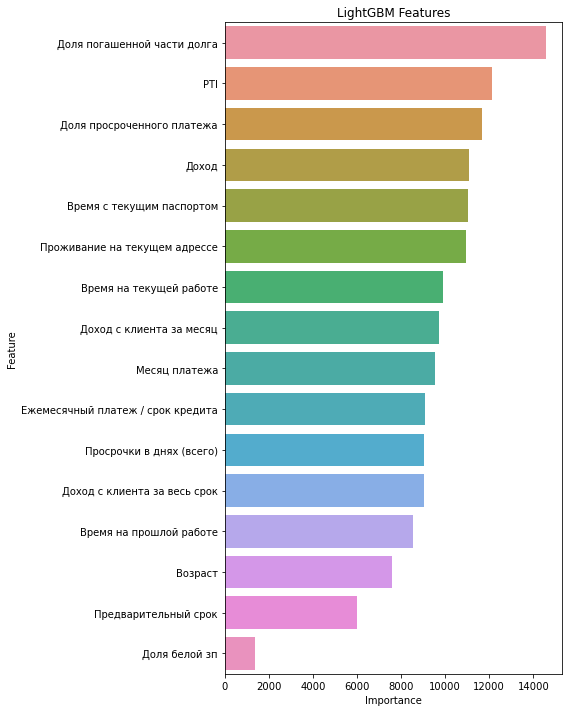

In [19]:
importance_df = pd.DataFrame({'Feature': name_feats_new, 'Importance': best_model.feature_importances_})
plt.figure(figsize=(8,10))
sns.barplot(x="Importance", y="Feature", data=importance_df.sort_values(by="Importance",ascending=False)[:16])
plt.title('LightGBM Features')
plt.tight_layout()

In [10]:
name_feats

['mob',
 'curr_rep_cap_share_one',
 'maxdelay_one',
 'MA_AGE',
 'MA_MONTH_AT_CURR_ADDRESS',
 'MA_MONTH_AT_CURR_PASSP',
 'MA_MONTH_AT_CURR_JOB',
 'MA_Time_Previous_Job',
 'MA_Proposed_Amount',
 'TOT_INCOME',
 'all_profit_per',
 'delays_one',
 'PTI',
 'PAYMD2TOTPAYM',
 'PARTWH_INCOME',
 'prof_per_month',
 'ratio_inst_amount',
 'MA_Gender_1',
 'MA_Education_1',
 'MA_Education_2',
 'MA_Education_3',
 'MA_Education_4',
 'MA_Marital_Status_2',
 'MA_Marital_Status_3',
 'MA_Marital_Status_4',
 'MA_Marital_Status_5',
 'MA_Marital_Status_6',
 'MANUMBEROFCHILD_1',
 'MANUMBEROFCHILD_2',
 'MANUMBEROFCHILD_3',
 'MANUMBEROFCHILD_4',
 'MA_Residential_Status_2',
 'MA_Residential_Status_3',
 'MA_Residential_Status_4',
 'MA_Residential_Status_5',
 'MA_Real_Estate_Owner_1',
 'MA_REG_Same_Fact_Addr_1',
 'MA_Exp_IND_1']